# Merge data

In [175]:
import pandas as pd

df_0 = pd.read_csv("../data/processed/01_master_uniprots.csv")
df_1 = pd.read_csv("../data/processed/02_annotated_proteins.csv")

df = pd.merge(df_0, df_1, on="uniprot_ac", how="left")

in_chembl = []

for v in df[["in_chembl", "chembl_count"]].values:
    if float(v[1]) > 0:
        in_chembl += [1]
    else:
        in_chembl += [int(v[0])]

df["in_chembl"] = in_chembl

is_vulnerable = []
for _, row in df.iterrows():
    if row["high_confidence"] == False:
        is_vulnerable += [0]
    else:
        if row["vi"] < -9.17575:
            is_vulnerable += [1]
        else:
            is_vulnerable += [0]

df["is_vulnerable"] = is_vulnerable


is_essential = []
for _, row in df.iterrows():
    if row["essentiality"] == "Essential" or row["essentiality"] == "Essential Domain":
        is_essential += [1]
    else:
        is_essential += [0]

is_growth_defect = []
for _, row in df.iterrows():
    if row["essentiality"] == "Growth Defect":
        is_growth_defect += [1]
    else:
        is_growth_defect += [0]

df["is_essential"] = is_essential
df["is_growth_defect"] = is_growth_defect


df = df.rename(columns={"high_confidence": "vi_hc"})

df = df[df["protein_evidence"] == True]

vi_hc = []
for v in df["vi_hc"].tolist():
    if v:
        vi_hc += [1]
    else:
        vi_hc += [0]

df["vi_hc"] = vi_hc

columns = ["uniprot_ac", "gene_name", "orf_id", "full_name", "protein_length", "is_known", "in_chembl", "is_essential", "is_growth_defect", "is_vulnerable", "chembl_count", "essentiality", "vi", "vi_hc", "pdb_count", "alphafold_conf", "panther_sf_name", "panther_annotation"]
df = df[columns]

# Upset plot

/home/mduranfrigola/miniconda3/envs/tabpfn/lib/python3.12/site-packages/upsetplot/data.py:385: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(False, inplace=True)
/home/mduranfrigola/miniconda3/envs/tabpfn/lib/python3.12/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.

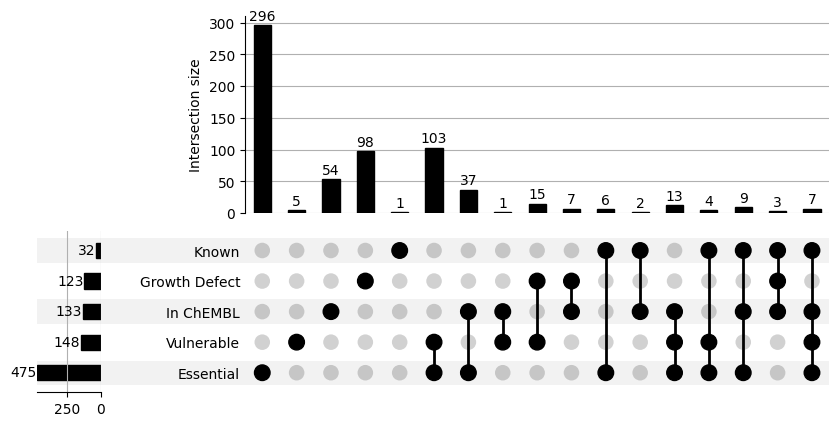

In [176]:
import matplotlib.pyplot as plt
import collections
from upsetplot import from_contents
from upsetplot import UpSet


data = collections.defaultdict(list)
for v in df[["uniprot_ac", "is_known", "in_chembl", "is_essential", "is_growth_defect", "is_vulnerable"]].values:
    if v[1] == 1:
        data["Known"] += [v[0]]
    if v[2] == 1:
        data["In ChEMBL"] += [v[0]]
    if v[3] == 1:
        data["Essential"] += [v[0]]
    if v[4] == 1:
        data["Growth Defect"] += [v[0]]
    if v[5] == 1:
        data["Vulnerable"] += [v[0]]

upset_data = from_contents(data)


ax_dict = UpSet(upset_data, subset_size="count", show_counts=True).plot()

plt.savefig("../assets/03_upset_plot.png", dpi=300)

In [177]:
all_selected = df[df["is_known"] == 1]["uniprot_ac"].tolist()
all_selected += df[df["in_chembl"] == 1]["uniprot_ac"].tolist()
all_selected += df[(df["is_vulnerable"] == 1) & (df["is_essential"] == 1)]["uniprot_ac"].tolist()
all_selected += df[(df["is_vulnerable"] == 1) & (df["is_growth_defect"] == 1)]["uniprot_ac"].tolist()
all_selected = sorted(set(all_selected))
print(len(all_selected))

262


In [178]:
n = 417 - len(all_selected)

df_ = df[~df["uniprot_ac"].isin(all_selected)]
df_ = df_.sort_values("vi", ascending=True)
df_ = df_[df_["is_essential"] == 1]
df_ = df_.head(n)

all_selected += df_["uniprot_ac"].tolist()

df_ = df[df["uniprot_ac"].isin(all_selected)]


In [179]:
df_ = df_.sort_values(by=["is_known", "in_chembl", "is_vulnerable", "is_essential", "is_growth_defect", "vi"], ascending=[False, False, False, False, False, True]).reset_index()
columns = list(df_.columns)

index = [i+1 for i in range(df_.shape[0])]
df_["rank"] = index
df_ = df_[["rank"] + columns]

df_.to_csv("../data/processed/03_first_selection_417.csv", index=False)

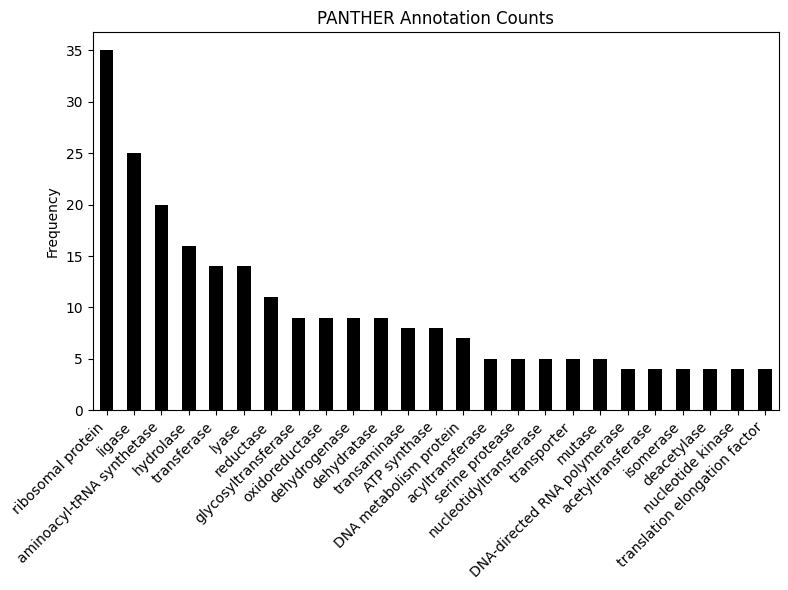

In [180]:
df_["panther_annotation"].value_counts()

df_["panther_annotation"].value_counts().head(25).plot(kind="bar", color="black", figsize=(8, 6))
plt.title("PANTHER Annotation Counts")
plt.xlabel("")
plt.ylabel("Frequency")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

plt.savefig("../assets/03_panther_annotation_counts.png", dpi=300)

In [181]:
df["panther_annotation"].value_counts()

panther_annotation
dehydrogenase                       133
oxidoreductase                       99
hydrolase                            77
transferase                          71
methyltransferase                    71
                                   ... 
carbohydrate phosphatase              1
homeodomain transcription factor      1
scaffold/adaptor protein              1
hydroxylase                           1
protease inhibitor                    1
Name: count, Length: 110, dtype: int64

In [182]:
df_["panther_annotation"].value_counts()

panther_annotation
ribosomal protein            35
ligase                       25
aminoacyl-tRNA synthetase    20
hydrolase                    16
transferase                  14
                             ..
translation factor            1
Hsp70 family chaperone        1
transketolase                 1
primase                       1
endoribonuclease              1
Name: count, Length: 72, dtype: int64

In [183]:
import numpy as np

np.percentile(df[df["high_confidence"] == True]["vi"], 25)

KeyError: 'high_confidence'

(array([   8.,   13.,   44.,   81.,  133.,  150.,  153.,  167.,  556.,
        2631.]),
 array([-17.953, -15.946, -13.939, -11.932,  -9.925,  -7.918,  -5.911,
         -3.904,  -1.897,   0.11 ,   2.117]),
 <BarContainer object of 10 artists>)

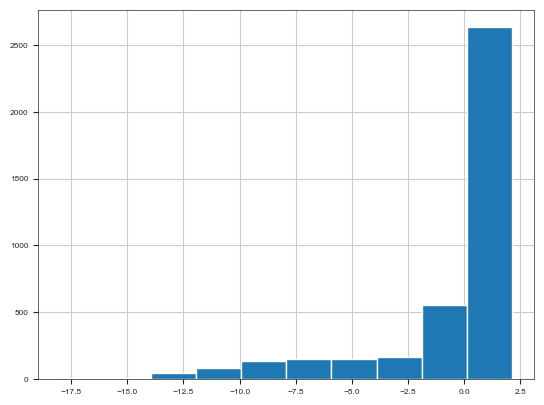

In [18]:
plt.hist(df["vi"])

In [17]:
for uniprot_ac in df[["uniprot_ac", "is_known", "in_chembl", "essentiality", ]]

Index(['orf_id', 'patric_name', 'essentiality', 'strain', 'vi', 'vi_lower',
       'vi_higher', 'high_confidence', 'uniprot_ac', 'in_chembl', 'is_known',
       'gene_name', 'full_name', 'organism', 'protein_length',
       'uniprot_reviewed', 'protein_evidence', 'pdb_count', 'alphafold_conf',
       'chembl_count', 'panther_family_name', 'panther_sf_name',
       'panther_annotation'],
      dtype='object')

In [15]:
df[df["is_known"] == 1].shape

df[df["in_chembl"] == 1].shape

(123, 23)

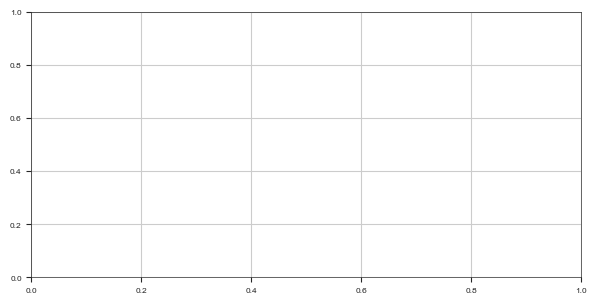

In [9]:
import matplotlib.pyplot as plt
import stylia

fig, axs = stylia.create_figure(1, 1, width=stylia.TWO_COLUMNS_WIDTH)

